In [1]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hiteshram
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification


100%|██████████| 401M/401M [00:07<00:00, 57.8MB/s]


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Rescaling
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import seaborn as sns
import pandas as pd

seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# Directory Path
train_dir = "/content/sports-balls-multiclass-image-classification/train"

# Dictionary to store subdirectory names and files counts
data = {'Category': [], 'Image Count': []}

# Loop through each subdirectory
for sub_dir in os.listdir(train_dir):
  sub_dir_path = os.path.join(train_dir, sub_dir)
  if os.path.isdir(sub_dir_path):
    # Count the number of files (images) of the subdirectory
    num_files = len([f for f in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path, f))])
    data['Category'].append(sub_dir)
    data['Image Count'].append(num_files)

In [4]:
# Convert the data to a pandas DataFrame
df = pd.DataFrame(data)

In [5]:
df

,Category,Image Count
0,volleyball,432
1,tennis_ball,490
2,table_tennis_ball,620
3,hockey_puck,390
4,hockey_ball,530
5,cricket_ball,581
6,american_football,384
7,baseball,400
8,golf_ball,549
9,rugby_ball,493


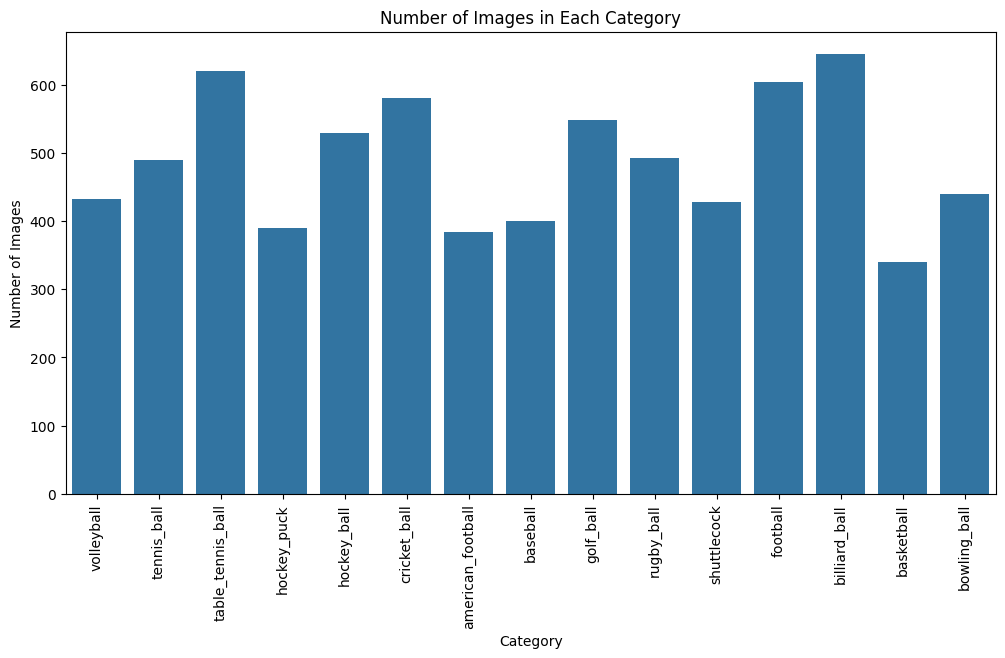

In [6]:
# Create the bar plot using Seaborn
plt.figure(figsize = (12, 6))
sns.barplot(x = 'Category', y = 'Image Count', data = df)
plt.xticks(rotation = 90)
plt.title("Number of Images in Each Category")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.show()

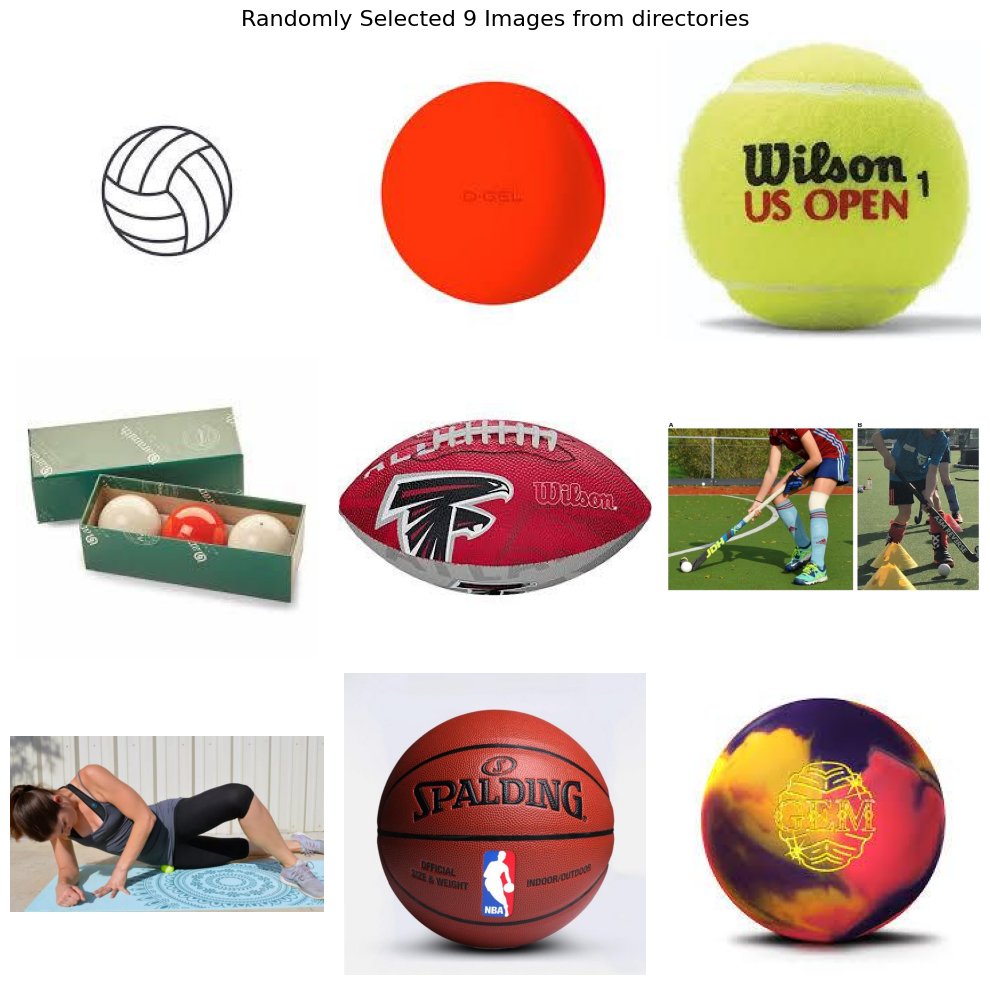

In [7]:
# Get all subdirectories and files in the directories
all_images = []
for sub_dir in os.listdir(train_dir):
  sub_dir_path = os.path.join(train_dir, sub_dir)
  if os.path.isdir(sub_dir_path):
    all_images.extend([os.path.join(sub_dir_path, f) for f in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path, f))])

# Random Select 9 images
random_images = random.sample(all_images, 9)

# Plotting the images in 3x3 grid
plt.figure(figsize = (10, 10))
for i, image_path in enumerate(random_images):
  img = mpimg.imread(image_path)
  plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.axis('off')

plt.suptitle("Randomly Selected 9 Images from directories", fontsize = 16)
plt.tight_layout()
plt.show()

In [8]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [9]:
# Data Augmentation layers (applied during training)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'), # Random Horizontal flip
    layers.RandomRotation(0.1), # Random Rotation
    layers.RandomZoom(0.1) # Random Zoom
])

In [10]:
# Load training & Validation datasets using image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    validation_split = 0.2,
    subset = 'training',
    seed = seed,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

Found 7328 files belonging to 15 classes.
Using 5863 files for training.


In [11]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    validation_split = 0.2,
    subset = 'validation',
    seed = seed,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

Found 7328 files belonging to 15 classes.
Using 1465 files for validation.


In [12]:
# Apply data augmentation only to the training data
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training = True), y))

In [13]:
# Optional: Prefetch data for performance improvement
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)

##**ResNet Model Building**

In [14]:
def residual_block(x, filters, kernel_size = 3, stride = 1):
  shortcut = x

  # First 1x1 Convolution to reduce dimensions
  x = layers.Conv2D(filters, kernel_size = 1, strides = stride, padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  # Second 3x3 Convolution
  x = layers.Conv2D(filters, kernel_size = kernel_size, strides = 1, padding = 'same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  # Third 1x1 Convolution to restore dimensions
  x = layers.Conv2D(filters * 4, kernel_size = 1, strides = 1, padding = 'same')(x)
  x = layers.BatchNormalization()(x)

  # Shortcut connection (adjust dimensions if necessary)
  if stride != 1 or shortcut.shape[-1] != filters * 4:
    shortcut = layers.Conv2D(filters * 4, kernel_size = 1, strides = stride, padding = 'same')(shortcut)
    shortcut = layers.BatchNormalization()(shortcut)

  # Add Shortcut
  x = layers.Add()([x, shortcut])
  x = layers.Activation('relu')(x)
  return x

In [15]:
def Resnet50(input_shape = (224, 224, 3), num_classes = 15):
  inputs = tf.keras.Input(shape = input_shape)

  # Intial Convolution and Maxpooling
  x = layers.Conv2D(64, kernel_size = 7, strides = 2, padding = 'same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D(pool_size = 3, strides = 2, padding = 'same')(x)

  # Residual Blocks (Bottleneck Architecture)
  x = residual_block(x, filters = 64)
  x = residual_block(x, filters = 64)
  x = residual_block(x, filters = 64)

  x = residual_block(x, filters = 128, stride = 2)
  x = residual_block(x, filters = 128)
  x = residual_block(x, filters = 128)
  x = residual_block(x, filters = 128)

  x = residual_block(x, filters = 256, stride = 2)
  x = residual_block(x, filters = 256)
  x = residual_block(x, filters = 256)
  x = residual_block(x, filters = 256)
  x = residual_block(x, filters = 256)
  x = residual_block(x, filters = 256)

  x = residual_block(x, filters = 512, stride = 2)
  x = residual_block(x, filters = 512)
  x = residual_block(x, filters = 512)

  # Global Average Pooling and Output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(num_classes, activation = 'softmax')(x)

  model = models.Model(inputs, x, name = 'ResNet50')
  return model

In [16]:
# Build the model
model = Resnet50(input_shape = (224, 224, 3))
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 256)    │              0 │ batch_normalization_3… │
│                      

 Total params: 23,618,447 (90.10 MB)

 Trainable params: 23,565,327 (89.89 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [17]:
# Compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ['accuracy'])

In [19]:
history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = 5)

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 221s 817ms/step - accuracy: 0.1385 - loss: 3.4361 - val_accuracy: 0.0908 - val_loss: 3.2953
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 128s 584ms/step - accuracy: 0.2143 - loss: 2.5210 - val_accuracy: 0.1563 - val_loss: 8.2942
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 113s 611ms/step - accuracy: 0.2634 - loss: 2.3884 - val_accuracy: 0.1618 - val_loss: 3.5023
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 137s 588ms/step - accuracy: 0.2951 - loss: 2.2495 - val_accuracy: 0.1570 - val_loss: 2.8312
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 139s 572ms/step - accuracy: 0.3159 - loss: 2.1848 - val_accuracy: 0.0983 - val_loss: 8.0962


<Axes: >

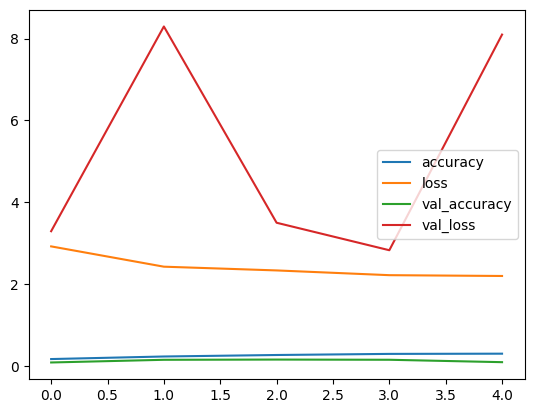

In [22]:
pd.DataFrame(history.history).plot()

##**Transfer Learning**

In [32]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Pretrained on imagedataset

In [33]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [34]:
# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the pre-trained base model
inputs = tf.keras.Input(shape=(224, 224, 3))

# Normalization layer
x = layers.Rescaling(1./255)(inputs)

# Optional: Apply augmentation (if augmentation is needed)
# x = layers.RandomFlip('horizontal')(x)
# x = layers.RandomRotation(0.1)(x)
# x = layers.RandomZoom(0.1)(x)

# Pass the inputs through the pre-trained ResNet50 base model
x = base_model(x, training=False)

# Global average pooling to reduce the output to a single vector per image
x = layers.GlobalAveragePooling2D()(x)

# Add a fully connected layer with the number of classes
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Dropout to reduce overfitting

# Final output layer with softmax activation for classification
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Build the model
model = models.Model(inputs, outputs)

model.summary()

NameError: name 'num_classes' is not defined

In [35]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,172,911 (96.03 MB)

 Trainable params: 528,399 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,056,800 (4.03 MB)

In [38]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Load training and validation datasets using image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Prefetch data for performance improvement
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Train the new layers while keeping the base model frozen
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5  # Adjust epochs as needed
)

Found 7328 files belonging to 15 classes.
Using 5863 files for training.
Found 7328 files belonging to 15 classes.
Using 1465 files for validation.
Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 44s 179ms/step - accuracy: 0.0949 - loss: 2.7831 - val_accuracy: 0.1249 - val_loss: 2.6207
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.1110 - loss: 2.6436 - val_accuracy: 0.1488 - val_loss: 2.6013
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - accuracy: 0.1298 - loss: 2.6057 - val_accuracy: 0.1706 - val_loss: 2.5694
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 48s 151ms/step - accuracy: 0.1382 - loss: 2.5894 - val_accuracy: 0.1556 - val_loss: 2.5697
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 121ms/step - accuracy: 0.1330 - loss: 2.5843 - val_accuracy: 0.1638 - val_loss: 2.5592


<Axes: >

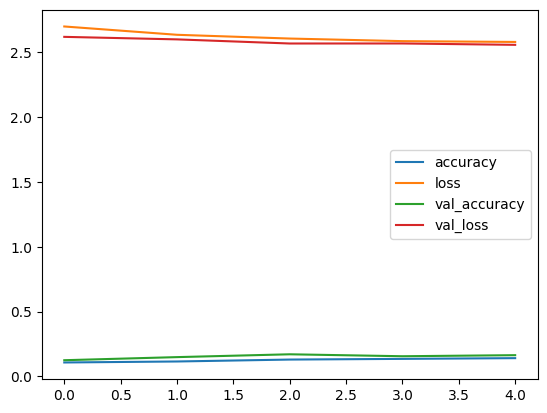

In [39]:
pd.DataFrame(history.history).plot()

##**Layers fine tuning**

In [40]:
# Load the pre-trained ResNet50 model excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Pretrained on imagedataset

# Unfreeze the last few layers of the base model for fine-tuning
base_model.trainable = True

fine_tune_at = 140

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [41]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 14,978,048 (57.14 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

In [42]:
# Compile the model again after unfreezing layers (lower learning rate for fine-tuning)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
# Fine-tune the model
fine_tune_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs = 20
)

Epoch 1/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.1601 - loss: 2.5563 - val_accuracy: 0.1761 - val_loss: 2.5411
Epoch 2/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - accuracy: 0.1584 - loss: 2.5523 - val_accuracy: 0.1795 - val_loss: 2.5363
Epoch 3/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 42s 127ms/step - accuracy: 0.1647 - loss: 2.5439 - val_accuracy: 0.1850 - val_loss: 2.5326
Epoch 4/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 128ms/step - accuracy: 0.1643 - loss: 2.5378 - val_accuracy: 0.1843 - val_loss: 2.5294
Epoch 5/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 40s 122ms/step - accuracy: 0.1608 - loss: 2.5411 - val_accuracy: 0.1891 - val_loss: 2.5278
Epoch 6/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 39s 114ms/step - accuracy: 0.1622 - loss: 2.5373 - val_accuracy: 0.1904 - val_loss: 2.5260
Epoch 7/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - accuracy: 0.1684 - loss: 2.5236 - val_accuracy: 0.1918 - val_loss: 2.5245
Epoch 8/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.1622 - loss: 2